In [1]:
from config import settings
from hannover_pylon.data import datamodules as dm
from pathlib import Path
from hannover_pylon.modelling.backbone.utils import FromBuffer , CutPSD, NormLayer
import matplotlib.pyplot as plt
from torch import nn 
%load_ext autoreload
%autoreload 2

/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


In [52]:
import pandas as pd 
import sqlite3
db_path = Path(settings.path.processed,'Welch(n_fft=16392, fs=1651, max_freq=825.5).db')
conn = sqlite3.connect(db_path)
# Read the 'meteo_data' table into a DataFrame
data_meteo = pd.read_sql('SELECT * FROM meteo_data', conn)
df_plot_meteo = data_meteo.pivot_table(index='date', columns='channel_name', values='value')
df_plot_meteo.index = pd.to_datetime(df_plot_meteo.index)
# Close the database connection
conn.close()

In [2]:
import numpy as np
freq_axis = np.linspace(0, 825.5, 8197)
db_path = Path(settings.path.processed,'Welch(n_fft=16392, fs=1651, max_freq=825.5).db')
columns= [f'psd_level{i+1}_{d}' for i in range(9) for d in ['x','y']]
transform_func = [nn.Sequential(FromBuffer(),CutPSD(freq_axis=freq_axis,freq_range=(0,150)),NormLayer(min_val=-5.46,max_val=4.96))]*len(columns)
query_key = f'''
    SELECT id FROM reshaped
    WHERE date BETWEEN "{settings.state.healthy_train.start}" AND "{settings.state.healthy_train.end}"
'''
data_loader = dm.PSDDataModule(db_path= db_path,table_name='reshaped', columns=columns,transform_func=transform_func, query_key=query_key, batch_size=248, return_dict=True, cached=True,num_workers=16)


In [3]:
data_loader.setup()

In [4]:
for batch in data_loader.train_dataloader():
    break

In [5]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from hannover_pylon.modelling.backbone import utils as ut

# =============================================================================
# AllToAllSensorAutoEncoder
# =============================================================================
class AllToAllSensorAutoEncoder(nn.Module):
    def __init__(self, sensor_list: list, psd_length: int = 1490,
                 shared_layers: list = [512, 128, 64], separated_layer: list = [32, 8],
                 latent_dim: int = 8, activation_str: str = 'relu'):
        """
        An autoencoder that processes all sensors (inputs and outputs are identical).

        For each sensor in sensor_list, a separate encoder branch extracts features.
        These features are concatenated and passed through a shared encoder to obtain
        a joint latent representation. A shared decoder then processes the latent vector,
        and sensor-specific decoder branches reconstruct each sensor.

        Args:
            sensor_list (list): List of sensor keys (e.g., ['psd_level1_x', 'psd_level1_y', ...]).
            psd_length (int): Length of each PSD vector.
            shared_layers (list): Hidden layer sizes for the shared encoder/decoder.
            separated_layer (list): Hidden layer sizes for the sensor-specific branches.
            latent_dim (int): Dimension of the joint latent space.
            activation_str (str): Activation function to use (e.g., 'relu').
        """
        super().__init__()
        if sensor_list is None:
            sensor_list = [f'psd_level{i+1}_{d}' for i in range(9) for d in ['x', 'y']]
        self.sensor_list = sensor_list
        self.psd_length = psd_length
        self.shared_layers = shared_layers
        self.separated_layer = separated_layer
        self.latent_dim = latent_dim
        self.activation_str = activation_str

        # Sensor-specific encoder branches.
        self.encoders_separated = nn.ModuleDict()
        for sensor in sensor_list:
            self.encoders_separated[sensor] = ut.build_layers(
                hidden_dims=[psd_length] + separated_layer,
                activation_list=[activation_str] * (len(separated_layer) - 1) + [None],
                batch_norm=False,
            )

        # Shared encoder: the input dimension is (number of sensors) * (separated_layer[-1]).
        input_dim_shared = len(sensor_list) * separated_layer[-1]
        self.shared_encoder = ut.build_layers(
            hidden_dims=[input_dim_shared] + shared_layers,
            activation_list=[activation_str] * len(shared_layers),
            batch_norm=False,
        )
        self.latent_layer_all = nn.Linear(shared_layers[-1], latent_dim)

        # Shared decoder: maps latent vector to a shared decoded feature space.
        self.shared_decoder = ut.build_layers(
            hidden_dims=[latent_dim] + shared_layers[::-1],
            activation_list=[activation_str] * len(shared_layers[::-1]),
            batch_norm=False,
        )
        # Determine the output dimension of the shared decoder.
        shared_decoder_output_dim = shared_layers[::-1][-1]
        # Sensor-specific decoder branches.
        self.decoders = nn.ModuleDict()
        for sensor in sensor_list:
            self.decoders[sensor] = ut.build_layers(
                hidden_dims=[shared_decoder_output_dim] + separated_layer[::-1] + [psd_length],
                activation_list=[activation_str] * (len(separated_layer)) + ['sigmoid'],
                batch_norm=False,
            )
        self.device_ = None

    def forward(self, x_dict):
        """
        Args:
            x_dict (dict): Dictionary where keys are sensor names (from sensor_list) and each
                           value is a tensor of shape (B, psd_length).
        Returns:
            dict: Contains:
                - "reconstruction": A dict mapping each sensor name to its reconstructed PSD tensor.
                - "latent": The joint latent representation (B, latent_dim).
        """
        if self.device_ is None:
            self.device_ = next(self.parameters()).device

        # Process each sensor through its own encoder branch.
        encoded_features = []
        for sensor in self.sensor_list:
            if sensor in x_dict:
                x = x_dict[sensor].to(self.device_)
                encoded = self.encoders_separated[sensor](x)
                encoded_features.append(encoded)
            else:
                raise ValueError(f"Input for sensor '{sensor}' is missing in x_dict.")

        # Concatenate all sensor-specific encoded features.
        concatenated = torch.cat(encoded_features, dim=1)  # shape: (B, len(sensor_list)*separated_layer[-1])
        # Process through the shared encoder.
        shared_encoded = self.shared_encoder(concatenated)
        # Obtain the joint latent representation.
        latent = self.latent_layer_all(shared_encoded)
        # Decode the latent vector using the shared decoder.
        shared_decoded = self.shared_decoder(latent)
        # Reconstruct each sensor's PSD using sensor-specific decoder branches.
        reconstruction = {}
        for sensor in self.sensor_list:
            reconstruction[sensor] = self.decoders[sensor](shared_decoded)

        return {"reconstruction": reconstruction, "latent": latent}


# =============================================================================
# Lightning Training Module for AllToAllSensorAutoEncoder
# =============================================================================
class AllToAllSensorTrainingModule(pl.LightningModule):
    def __init__(self, sensor_list: list, 
                 psd_length: int = 1490, 
                 shared_layers: list = [512, 128, 64],
                 separated_layer: list = [32, 8],
                 latent_dim: int = 8, 
                 activation_str: str = 'relu',
                 lr: float = 1e-3):
        """
        Lightning module to train the AllToAllSensorAutoEncoder.
        The loss is computed as the average MSE reconstruction loss across all sensors.

        Args:
            sensor_list (list): List of sensor keys.
            psd_length (int): Length of each PSD vector.
            shared_layers (list): Hidden layer sizes for the shared encoder/decoder.
            separated_layer (list): Hidden layer sizes for the sensor-specific branches.
            latent_dim (int): Dimension of the joint latent space.
            activation_str (str): Activation function to use.
            lr (float): Learning rate.
        """
        super().__init__()
        self.model = AllToAllSensorAutoEncoder(
            sensor_list=sensor_list,
            psd_length=psd_length,
            shared_layers=shared_layers,
            separated_layer=separated_layer,
            latent_dim=latent_dim,
            activation_str=activation_str
        )
        self.loss_fn = nn.MSELoss()
        self.lr = lr
        self.save_hyperparameters(ignore=["model"])

    def forward(self, batch):
        return self.model(batch)
    
    def training_step(self, batch, batch_idx):
        outputs = self(batch)
        reconstruction = outputs["reconstruction"]
        total_loss = 0.0
        sensor_count = 0
        
        for sensor, rec in reconstruction.items():
            target = batch[sensor].to(rec.device)
            loss_sensor = self.loss_fn(rec, target)
            total_loss += loss_sensor
            sensor_count += 1
            
        total_loss = total_loss / sensor_count if sensor_count > 0 else total_loss
        self.log("train_loss", total_loss, prog_bar=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        outputs = self(batch)
        reconstruction = outputs["reconstruction"]
        total_loss = 0.0
        sensor_count = 0
        
        for sensor, rec in reconstruction.items():
            target = batch[sensor].to(rec.device)
            loss_sensor = self.loss_fn(rec, target)
            total_loss += loss_sensor
            sensor_count += 1
            
        total_loss = total_loss / sensor_count if sensor_count > 0 else total_loss
        self.log("val_loss", total_loss, prog_bar=True)
        return total_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [85]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torch

model = AllToAllSensorTrainingModule(
    sensor_list=None,
    psd_length=1490,
    shared_layers=[64,32],
    separated_layer=[512,128, 64],
    latent_dim=4,
    activation_str='relu',
    lr=1e-3
)


# Define a model checkpoint callback to save the best models.
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',              # Monitor the validation loss.
    dirpath='checkpoints',           # Directory to save checkpoints.
    filename='autoencoder-{epoch:02d}-{val_loss:.4f}', 
    save_top_k=3,                    # Save the 3 best models.
    mode='min'
)

# Define an early stopping callback (optional).
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=True,
    mode='min'
)

# Create the Trainer instance.
trainer = Trainer(
    max_epochs=250,
    callbacks=[checkpoint_callback, early_stop_callback],
    accelerator='gpu'
)

# Start training.
trainer.fit(model,data_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/hannover-pylon/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                      | Params | Mode 
--------------------------------------------------------------
0 | model   | AllToAllSensorAutoEncoder | 30.3 M | train
1 | loss_fn | MSELoss                   | 0      | train
--------------------------------------------------------------
30.3 M    Trainable params
0         Non-trainable params
30.3 M    Total params
121.288   Total estimated model params size (MB)
173       Modules in train mode
2         Modules in eval mode


DataModule already setup
Epoch 0: 100%|██████████| 320/320 [03:04<00:00,  1.73it/s, v_num=208, train_loss=0.000705, val_loss=0.0013]

Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 320/320 [03:00<00:00,  1.77it/s, v_num=208, train_loss=0.0007, val_loss=0.00105] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 320/320 [03:02<00:00,  1.75it/s, v_num=208, train_loss=0.000776, val_loss=0.000787]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 320/320 [03:01<00:00,  1.76it/s, v_num=208, train_loss=0.00051, val_loss=0.000593] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 4: 100%|██████████| 320/320 [03:03<00:00,  1.75it/s, v_num=208, train_loss=0.000205, val_loss=0.000483]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 320/320 [03:00<00:00,  1.78it/s, v_num=208, train_loss=0.000296, val_loss=0.000482]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 320/320 [03:01<00:00,  1.76it/s, v_num=208, train_loss=0.000595, val_loss=0.000466]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 320/320 [03:04<00:00,  1.74it/s, v_num=208, train_loss=0.000216, val_loss=0.000439]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 320/320 [03:05<00:00,  1.73it/s, v_num=208, train_loss=0.000209, val_loss=0.000389]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 320/320 [03:09<00:00,  1.69it/s, v_num=208, train_loss=0.000237, val_loss=0.000355]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 320/320 [03:22<00:00,  1.58it/s, v_num=208, train_loss=0.000243, val_loss=0.000332]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 320/320 [03:22<00:00,  1.58it/s, v_num=208, train_loss=0.000248, val_loss=0.000327]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 320/320 [03:22<00:00,  1.58it/s, v_num=208, train_loss=0.000161, val_loss=0.000296]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 320/320 [03:02<00:00,  1.75it/s, v_num=208, train_loss=0.000203, val_loss=0.000293]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 320/320 [03:03<00:00,  1.75it/s, v_num=208, train_loss=0.000278, val_loss=0.000277]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 320/320 [03:03<00:00,  1.74it/s, v_num=208, train_loss=0.000179, val_loss=0.000265]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 320/320 [03:04<00:00,  1.73it/s, v_num=208, train_loss=0.000313, val_loss=0.000262]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 320/320 [03:03<00:00,  1.74it/s, v_num=208, train_loss=0.000206, val_loss=0.000255]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 320/320 [03:03<00:00,  1.75it/s, v_num=208, train_loss=0.000308, val_loss=0.000253]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 320/320 [03:04<00:00,  1.74it/s, v_num=208, train_loss=0.000207, val_loss=0.00024] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 320/320 [03:03<00:00,  1.74it/s, v_num=208, train_loss=0.000195, val_loss=0.000239]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 320/320 [03:01<00:00,  1.76it/s, v_num=208, train_loss=0.000279, val_loss=0.000239]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 320/320 [03:03<00:00,  1.74it/s, v_num=208, train_loss=0.00024, val_loss=0.000239] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 320/320 [03:02<00:00,  1.76it/s, v_num=208, train_loss=0.000333, val_loss=0.000237]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 35: 100%|██████████| 320/320 [03:28<00:00,  1.53it/s, v_num=208, train_loss=0.00013, val_loss=0.000223] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 41: 100%|██████████| 320/320 [03:25<00:00,  1.56it/s, v_num=208, train_loss=0.000171, val_loss=0.000216]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 43: 100%|██████████| 320/320 [03:15<00:00,  1.63it/s, v_num=208, train_loss=0.000145, val_loss=0.000211]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 52: 100%|██████████| 320/320 [03:01<00:00,  1.76it/s, v_num=208, train_loss=9.45e-5, val_loss=0.000207] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 60: 100%|██████████| 320/320 [03:03<00:00,  1.74it/s, v_num=208, train_loss=0.000226, val_loss=0.000204]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 61: 100%|██████████| 320/320 [03:05<00:00,  1.73it/s, v_num=208, train_loss=0.000139, val_loss=0.000203]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 65: 100%|██████████| 320/320 [03:03<00:00,  1.75it/s, v_num=208, train_loss=0.000159, val_loss=0.000203]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 67: 100%|██████████| 320/320 [03:03<00:00,  1.75it/s, v_num=208, train_loss=0.000121, val_loss=0.0002]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 74: 100%|██████████| 320/320 [03:03<00:00,  1.75it/s, v_num=208, train_loss=0.00016, val_loss=0.0002]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 75: 100%|██████████| 320/320 [03:02<00:00,  1.75it/s, v_num=208, train_loss=0.0002, val_loss=0.000196]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 77: 100%|██████████| 320/320 [03:18<00:00,  1.61it/s, v_num=208, train_loss=0.000172, val_loss=0.000196]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 85: 100%|██████████| 320/320 [03:11<00:00,  1.67it/s, v_num=208, train_loss=0.000166, val_loss=0.000192]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 88: 100%|██████████| 320/320 [04:21<00:00,  1.22it/s, v_num=208, train_loss=0.000105, val_loss=0.000188]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 98: 100%|██████████| 320/320 [03:19<00:00,  1.60it/s, v_num=208, train_loss=0.000255, val_loss=0.000198]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 98: 100%|██████████| 320/320 [03:19<00:00,  1.60it/s, v_num=208, train_loss=0.000255, val_loss=0.000198]


In [7]:
best_model_path = checkpoint_callback.best_model_path
# print mse loss
print(checkpoint_callback.best_model_score.item())
best_model = AllToAllSensorTrainingModule.load_from_checkpoint(best_model_path)

0.0002488848112989217


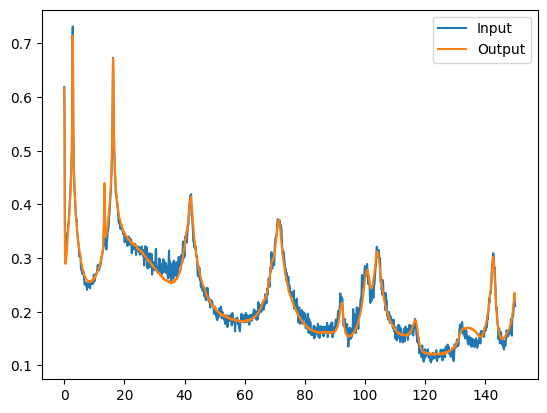

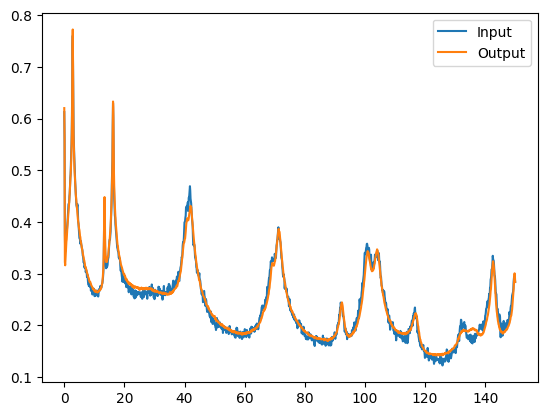

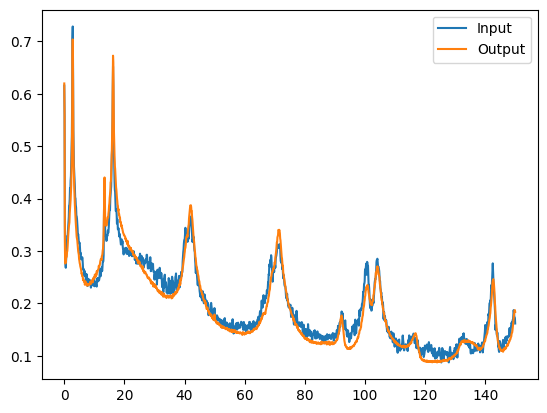

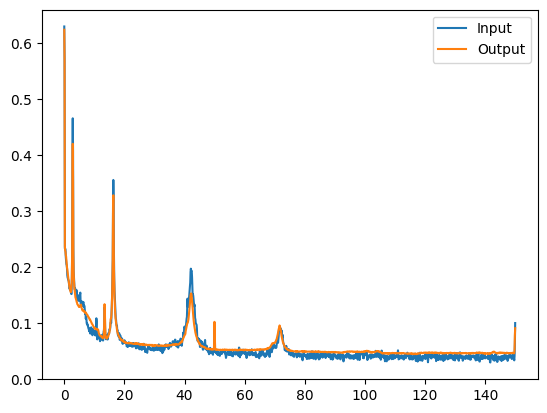

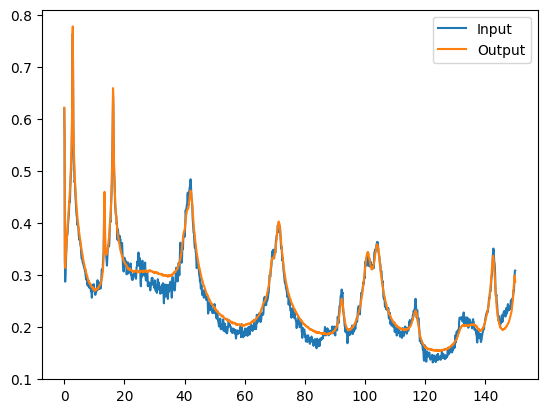

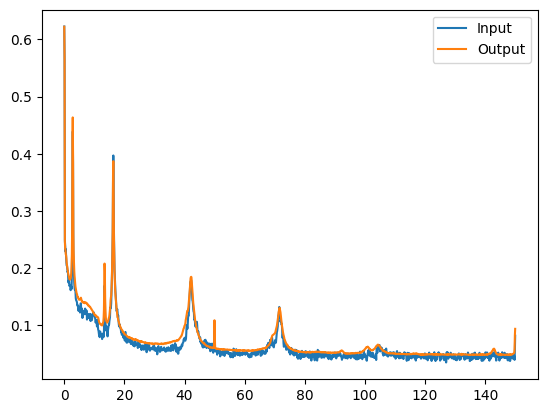

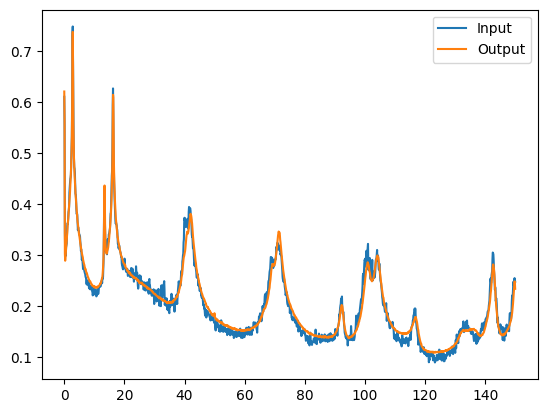

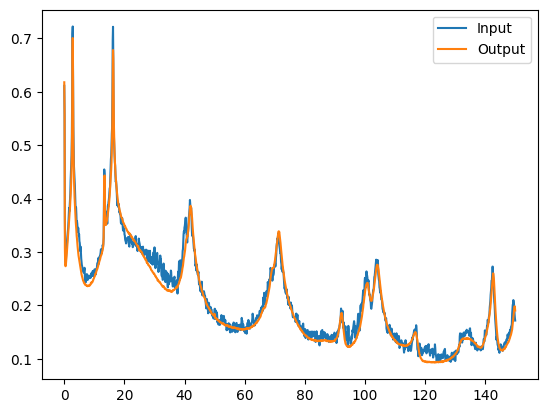

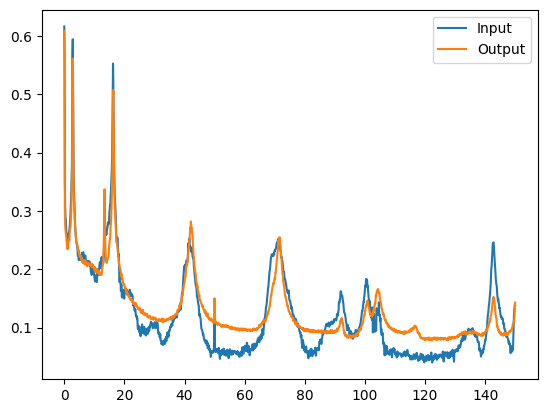

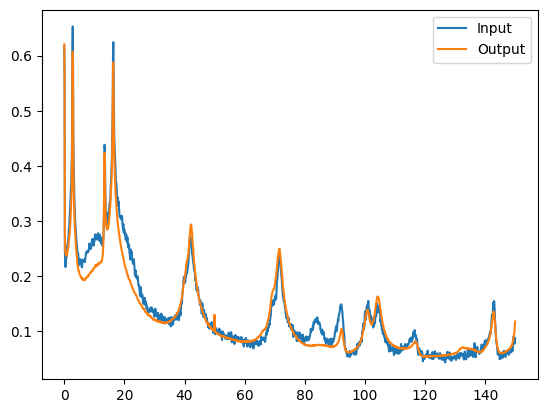

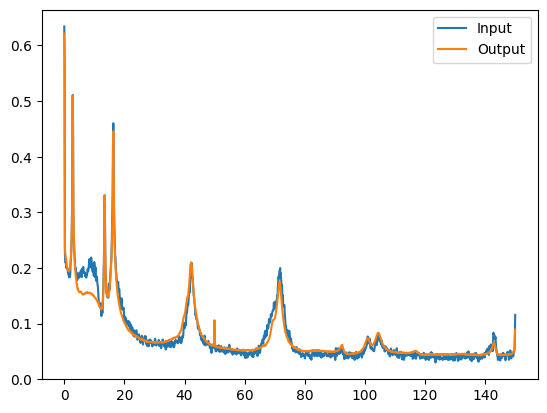

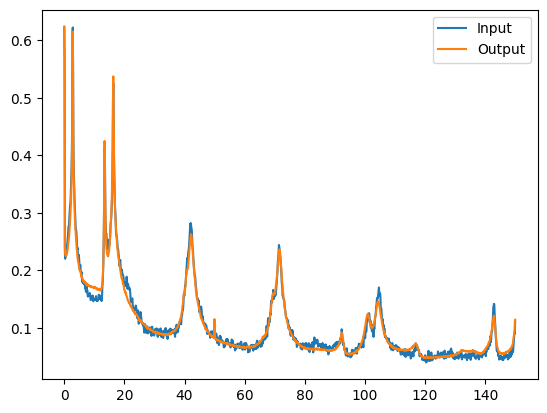

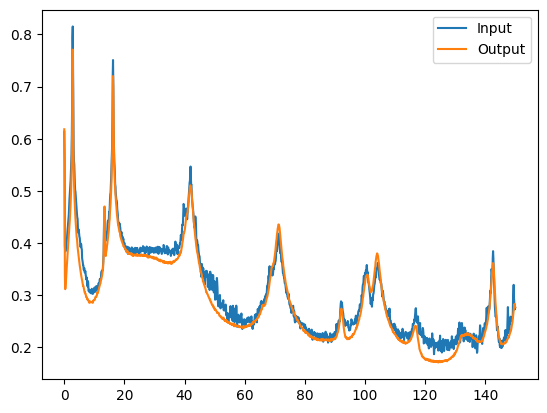

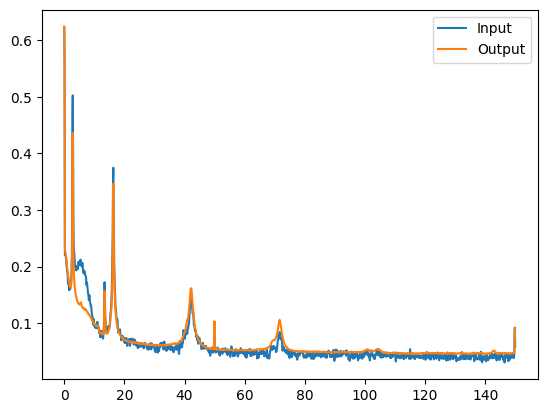

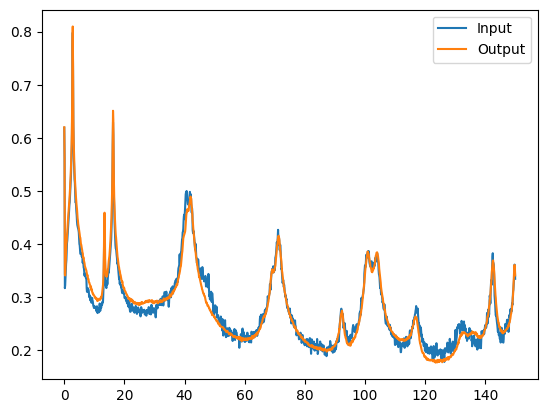

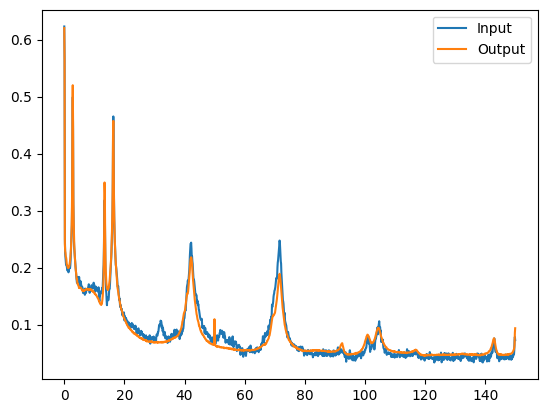

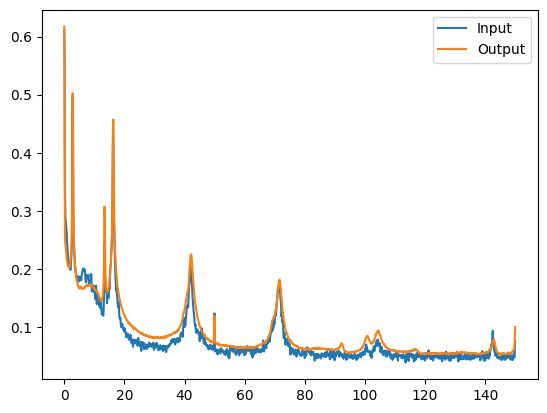

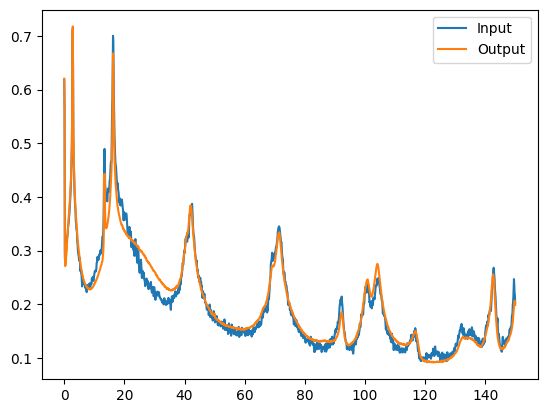

In [8]:
best_model.eval()
batch = next(iter(data_loader.val_dataloader()))
psd_out = best_model(batch)
psd_in = batch['psd_level1_x']
psd_out = psd_out['reconstruction']['psd_level1_x']                                 

for i in range(18):
    plt.figure()
    plt.plot(freq_axis[0:1490], psd_in[i].detach().numpy(), label='Input')
    plt.plot(freq_axis[0:1490], psd_out[i].cpu().detach().numpy(), label='Output')
    plt.legend()
    plt.show()
    plt.close()

In [9]:
import torch
import torch.nn as nn

class Detector(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.eval()  # Set the model to evaluation mode
        self.device = next(model.parameters()).device

    def mse(self, x_dict):
        """
        Compute the 90th percentile squared error for each sensor and return
        the average error across all sensors.
        
        Args:
            x_dict (dict): Dictionary where keys are sensor names (e.g., "psd_level1_x")
                           and values are tensors of shape (B, psd_length).
        Returns:
            Tensor: Aggregated anomaly score for each sample (shape: (B,))
        """
        errors = {}
        with torch.no_grad():
            outputs = self.model(x_dict)  # outputs is a dict: {"reconstruction": {...}, "latent": ...}
            reconstructions = outputs["reconstruction"]
        
        # Iterate over each sensor in the reconstruction dictionary.
        for sensor, x_hat in reconstructions.items():
            # Get the corresponding input tensor and ensure it's on the correct device.
            x = x_dict[sensor].to(self.device)
            # Compute element-wise squared error.
            error = (x - x_hat) ** 2
            # Compute the 90th percentile error along the feature dimension (dim=1)
            quantile_error = torch.quantile(error, q=0.9, dim=1)  # shape: (B,)
            errors[sensor] = quantile_error.cpu().numpy()
        
        return errors

    def forward(self, x_dict):
        return self.mse(x_dict)


In [10]:

detector = Detector(best_model)

# Get a batch from your data loader (which yields a dict with key "psd").
batch = next(iter(data_loader.val_dataloader()))

# Compute the damage metric for this batch.
damage_metric = detector(batch)  # returns a tensor of shape (B,)

print("Damage metric (90th percentile reconstruction error) per sample:")
print(damage_metric)

Damage metric (90th percentile reconstruction error) per sample:
{'psd_level1_x': array([4.0305775e-04, 3.1668702e-04, 9.7890000e-04, 1.5984895e-04,
       5.4758874e-04, 2.3807296e-04, 3.7489325e-04, 6.3525350e-04,
       2.2710513e-03, 1.6494590e-03, 3.6084390e-04, 2.1974328e-04,
       1.3061631e-03, 2.1385722e-04, 5.5611250e-04, 3.3874679e-04,
       5.7148159e-04, 1.0461028e-03, 4.3283237e-04, 1.7379393e-04,
       4.6287835e-04, 1.8724882e-03, 6.2302069e-04, 1.9170600e-04,
       2.5125701e-04, 5.7130720e-04, 1.1795384e-03, 1.8187392e-03,
       3.8709611e-04, 4.4954603e-04, 5.6543812e-04, 1.7745186e-04,
       4.6228827e-04, 6.8604271e-04, 1.2483075e-03, 7.4764586e-04,
       1.3417866e-03, 3.7793422e-03, 3.5715546e-04, 1.6866957e-03,
       3.7094584e-04, 2.6778414e-04, 2.5435697e-04, 4.0085643e-04,
       3.8735542e-04, 1.6263356e-04, 3.9625241e-04, 1.1571114e-04,
       5.8564212e-04, 1.0854654e-03, 3.7204145e-04, 3.7230115e-04,
       3.7088964e-04, 1.6975585e-04, 2.4090751e

In [11]:
import re 
def transform_dict_to_lists(data):
    flattened = [(k, v) for k, vals in data.items() for v in vals]
    keys, values = zip(*flattened)
    return list(keys), list(values)
def split_sensor_keys(sensor_keys):
    """
    Splits sensor keys of the format 'psd_level{number}_{direction}' into two lists:
    one for level (as integers) and one for direction (as strings).

    Args:
        sensor_keys (list): List of sensor keys, e.g., ['psd_level1_x', 'psd_level1_y', ...]

    Returns:
        tuple: (levels, directions)
            levels (list of int): The level numbers extracted from the sensor keys.
            directions (list of str): The corresponding directions ('x' or 'y').
    """
    pattern = re.compile(r'psd_level(\d+)_([xy])')
    levels = []
    directions = []
    
    for key in sensor_keys:
        match = pattern.match(key)
        if match:
            level_str, direction = match.groups()
            levels.append(int(level_str))
            directions.append(direction)
        else:
            raise ValueError(f"Sensor key '{key}' does not match the expected format.")
    
    return levels, directions


In [12]:
freq_axis = np.linspace(0, 825.5, 8197)
db_path = Path(settings.path.processed,'Welch(n_fft=16392, fs=1651, max_freq=825.5).db')
columns=['date']+ [f'psd_level{i+1}_{d}' for i in range(9) for d in ['x','y']]
transform_func = [nn.Identity()]+[nn.Sequential(FromBuffer(),CutPSD(freq_axis=freq_axis,freq_range=(0,150)),NormLayer(min_val=-5.46,max_val=4.96))]*len(columns) 
query_key = f'''
    SELECT id FROM reshaped
   '''
data_loader = dm.PSDDataModule(db_path= db_path,table_name='reshaped', columns=columns,transform_func=transform_func, query_key=query_key, batch_size=128, return_dict=True, cached=False,num_workers=8) 
data_loader.setup()


In [13]:
import torch
import numpy as np
import pandas as pd

df_list = []
# Iterate over all batches from the data loader.
for batch in data_loader.all_dataloader():
    # Get the common 'date' field.
    dates = batch["date"]
    if isinstance(dates, torch.Tensor):
        dates = dates.cpu().numpy()
    print(dates[0])

        # Compute the sensor's reconstruction error using the model.
    with torch.no_grad():
        # Note: detector.model returns a dictionary with sensor keys.
        mse = detector(batch)
    mse.update({"date": dates})

    df_temp = pd.DataFrame(mse)
    df_list.append(df_temp)

# Concatenate all batch DataFrames.
df_res = pd.concat(df_list, ignore_index=True)
print(df_res.head())


2020-08-01 00:02:00
2020-08-01 21:21:00
2020-08-02 18:51:00
2020-08-03 16:20:00
2020-08-04 13:50:00
2020-08-05 11:09:00
2020-08-06 08:29:00
2020-08-07 05:48:00
2020-08-08 03:18:00
2020-08-09 00:47:00
2020-08-09 22:07:00
2020-08-10 19:26:00
2020-08-11 16:46:00
2020-08-12 14:05:00
2020-08-13 11:35:00
2020-08-14 09:04:00
2020-08-15 06:34:00
2020-08-16 03:54:00
2020-08-17 01:23:00
2020-08-17 22:43:00
2020-08-18 20:02:00
2020-08-19 17:32:00
2020-08-20 14:51:00
2020-08-21 12:11:00
2020-08-22 09:30:00
2020-08-23 06:50:00
2020-08-24 04:19:00
2020-08-25 01:39:00
2020-08-25 22:58:00
2020-08-26 20:18:00
2020-08-27 17:47:00
2020-08-28 15:17:00
2020-08-29 12:36:00
2020-08-30 10:06:00
2020-08-31 07:45:00
2020-09-01 05:15:00
2020-09-02 02:44:00
2020-09-03 00:04:00
2020-09-03 21:24:00
2020-09-04 18:43:00
2020-09-05 16:03:00
2020-09-06 14:02:00
2020-09-07 11:32:00
2020-09-08 09:01:00
2020-09-09 06:21:00
2020-09-10 03:40:00
2020-09-11 01:10:00
2020-09-11 22:34:00
2020-09-12 19:54:00
2020-09-13 17:13:00


In [16]:
df_res

,psd_level1_x,psd_level1_y,psd_level2_x,psd_level2_y,psd_level3_x,psd_level3_y,psd_level4_x,psd_level4_y,psd_level5_x,psd_level5_y,psd_level6_x,psd_level6_y,psd_level7_x,psd_level7_y,psd_level8_x,psd_level8_y,psd_level9_x,psd_level9_y,date
0,0.000473,0.000825,0.000438,0.000431,0.000362,0.000602,0.000438,0.000529,0.000326,0.000790,0.000388,0.000581,0.000253,0.000449,0.000434,0.000489,0.000288,0.000681,2020-08-01 00:02:00
1,0.000361,0.000432,0.000191,0.000251,0.000269,0.000421,0.000291,0.000362,0.000241,0.000407,0.000263,0.000805,0.000243,0.000313,0.000372,0.000231,0.000153,0.000346,2020-08-01 00:12:00
2,0.000400,0.000287,0.000076,0.000175,0.000203,0.000193,0.000163,0.000174,0.000125,0.002886,0.000109,0.001885,0.000098,0.000209,0.000433,0.000223,0.000066,0.000111,2020-08-01 00:22:00
3,0.000440,0.000245,0.000084,0.000099,0.000123,0.000179,0.000134,0.000145,0.000095,0.000160,0.000081,0.002240,0.000074,0.000207,0.000433,0.000142,0.000062,0.000097,2020-08-01 00:32:00
4,0.003559,0.002941,0.000386,0.000736,0.001262,0.002204,0.003475,0.002931,0.001693,0.002203,0.001084,0.002061,0.000735,0.001400,0.000991,0.001748,0.001349,0.001223,2020-08-01 00:42:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51045,0.000949,0.000844,0.000839,0.000753,0.001070,0.000928,0.001194,0.001222,0.000982,0.000954,0.001484,0.001341,0.001343,0.001354,0.001135,0.001103,0.001539,0.001599,2021-07-31 23:16:00
51046,0.000896,0.000823,0.000831,0.000778,0.001013,0.000894,0.001165,0.001210,0.000981,0.000902,0.001309,0.001390,0.001366,0.001359,0.001037,0.000983,0.001474,0.001431,2021-07-31 23:26:00
51047,0.001016,0.000850,0.000825,0.000725,0.000993,0.000988,0.002866,0.001337,0.000954,0.001014,0.001379,0.001279,0.001486,0.001404,0.001014,0.001053,0.001526,0.001530,2021-07-31 23:36:00
51048,0.000776,0.000612,0.000621,0.000572,0.000829,0.000769,0.000850,0.000820,0.000684,0.000739,0.000901,0.001045,0.000744,0.001133,0.000626,0.000678,0.001020,0.001452,2021-07-31 23:46:00


In [ ]:
import pandas as pd

df_res['date'] = pd.to_datetime(df_res['date'])
df_res = df_res.set_index('date')


In [22]:

# Convert the date column to datetime.

# Define training period boundaries using your settings.
train_start = pd.to_datetime(settings.state.healthy_train.start)
train_end   = pd.to_datetime(settings.state.healthy_train.end)
# normalize each column using 99 percentile and 1 percentile of the training data
min_val = df_res.loc[train_start:train_end].quantile(0.01)
max_val = df_res.loc[train_start:train_end].quantile(0.99)
df_res = (df_res - min_val) / (max_val - min_val)


In [44]:
df_reset.set_index('date',inplace=True)


KeyError: "None of ['date'] are in the columns"

In [46]:
df_reset.loc[train_start:train_end].quantile(0.99)

psd_level1_x    1.0
psd_level1_y    1.0
psd_level2_x    1.0
psd_level2_y    1.0
psd_level3_x    1.0
psd_level3_y    1.0
psd_level4_x    1.0
psd_level4_y    1.0
psd_level5_x    1.0
psd_level5_y    1.0
psd_level6_x    1.0
psd_level6_y    1.0
psd_level7_x    1.0
psd_level7_y    1.0
psd_level8_x    1.0
psd_level8_y    1.0
psd_level9_x    1.0
psd_level9_y    1.0
Name: 0.99, dtype: float64

In [30]:
df_reset = df_res.reset_index()
df_melted = pd.melt(df_reset, id_vars=['date'], 
                    var_name='sensor_name', value_name='mse')
df_melted[['level', 'direction']] = df_melted['sensor_name'].str.extract(r'level(\d+)_(x|y)')



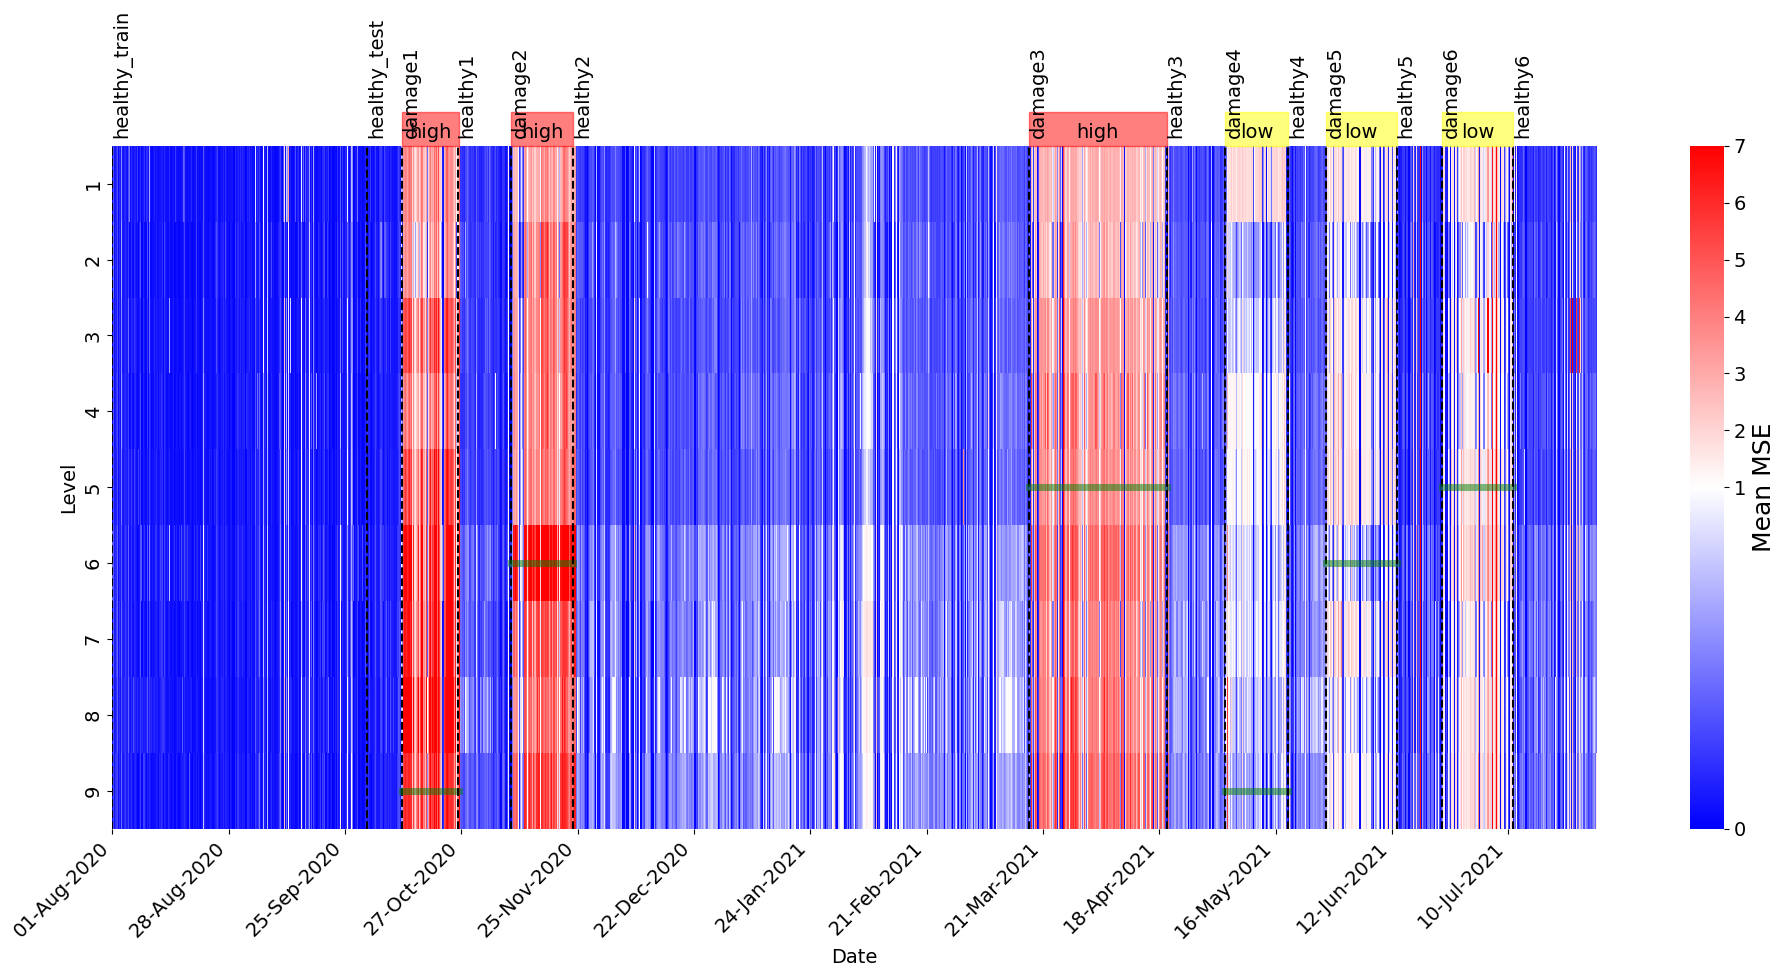

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
col_of_interest = 'mse'

# Ensure the date column is in datetime format.
df_melted['date'] = pd.to_datetime(df_melted['date'])

# Optionally, select a single sensor direction for the control chart.
# For instance, if you want to focus on the "y" direction:
df_control = df_melted
# =============================================================================
# 2. Pivot the DataFrame for a Heatmap
# =============================================================================
# Create a pivot table with sensor level as the index, date as columns, and mean mse as values.
df_pivot = df_control.pivot_table(index='level', columns='date', values=col_of_interest, aggfunc='max')
#df_pivot = df_pivot.rolling('1h').mean().T
# Ensure the pivot table's columns are datetime objects.
df_pivot.columns = pd.to_datetime(df_pivot.columns)

# =============================================================================
# 3. Create a Custom Date Formatter for the x-axis
# =============================================================================
def create_date_formatter(column_dates):
    """Return a custom formatter function for datetime labels."""
    def custom_date_format(x, pos=None):
        try:
            idx = int(x)
            if 0 <= idx < len(column_dates):
                return column_dates[idx].strftime('%d-%b-%Y')
            return ''
        except Exception:
            return ''
    return FuncFormatter(custom_date_format)

# =============================================================================
# 4. Define Custom Colormap and Norm
# =============================================================================
# Create a custom colormap from blue to white to red.
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_bwr', ['blue', 'white', 'red'])
# Use TwoSlopeNorm to center the colormap at 1, with vmin=0 and vmax=2.
norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=7)

# =============================================================================
# 5. Plot the Control Chart (Heatmap)
# =============================================================================
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

sns.heatmap(
    df_pivot,
    cmap=custom_cmap,                # Use the custom colormap.
    norm=norm,                       # Apply the normalization so that white is at 1.
    cbar_kws={'label': 'Mean MSE'},   # Label for the color bar.
    ax=ax
)

ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Level', fontsize=14)

# Create a list of dates from the pivot table columns.
dates_list = list(df_pivot.columns)
ax.xaxis.set_major_formatter(create_date_formatter(dates_list))
ax.xaxis.set_major_locator(MaxNLocator(nbins=15))  # Limit the number of x-axis ticks

# Rotate x-axis labels for better readability.
plt.xticks(rotation=45, ha='right')

# =============================================================================
# 6. (Optional) Annotate Events on the Chart
# =============================================================================
# If you have events defined in your settings, you can annotate the plot.
# For example, if events are stored as a dictionary in settings.state:
# events = {
#     "Event1": {"start": "2020-01-10", "end": "2020-01-12", "closest_sensor": 3, "severity": "high"},
#     "Event2": {"start": "2020-02-05", "end": "2020-02-07", "closest_sensor": 2, "severity": "low"}
# }
events = settings.state.to_dict()
for event_i, event_info in events.items():
    start = pd.to_datetime(event_info['start'])
    end = pd.to_datetime(event_info['end'])
    # Find approximate x-axis indices corresponding to start and end dates.
    idx_start = np.searchsorted(df_pivot.columns, start)
    idx_end = np.searchsorted(df_pivot.columns, end)
    
    # Draw a vertical line at the event start.
    ax.axvline(idx_start, color='black', linestyle='--', label=f'{event_i} start')
    ax.text(idx_start, -0.1, f'{event_i}', rotation=90, va='bottom', ha='left')
    
    # Draw a horizontal line at the sensor level closest to the event (if provided).
    level = event_info.get('closest_sensor', None)
    if level is not None:
        ax.axhline(level - 0.5, xmin=idx_start/len(df_pivot.columns), xmax=idx_end/len(df_pivot.columns),
                   color='green', linestyle='-', lw=5, alpha=0.5)
    
    # Draw a rectangle above the plot indicating severity.
    severity = event_info.get('severity', None)
    if severity is not None:
        color = 'red' if severity == 'high' else 'yellow'
        box_height = 0.05  # Height of the severity box.
        ax.add_patch(Rectangle(
            (idx_start, 1),       # Position above the plot.
            width=idx_end - idx_start,
            height=box_height,
            color=color,
            alpha=0.5,
            transform=ax.get_xaxis_transform(),
            clip_on=False
        ))
        ax.text((idx_start + idx_end) / 2, -0.1 + box_height, severity,
                ha='center', va='bottom', color='black')

# =============================================================================
# 7. Finalize and Show the Plot
# =============================================================================
plt.tight_layout()
plt.show()


In [66]:
df_melted

,date,sensor_name,mse,level,direction
0,2020-08-01 00:02:00,psd_level1_x,0.072850,1,x
1,2020-08-01 00:12:00,psd_level1_x,0.050635,1,x
2,2020-08-01 00:22:00,psd_level1_x,0.058450,1,x
3,2020-08-01 00:32:00,psd_level1_x,0.066282,1,x
4,2020-08-01 00:42:00,psd_level1_x,0.685854,1,x
...,...,...,...,...,...
918895,2021-07-31 23:16:00,psd_level9_y,0.325691,9,y
918896,2021-07-31 23:26:00,psd_level9_y,0.290057,9,y
918897,2021-07-31 23:36:00,psd_level9_y,0.311074,9,y
918898,2021-07-31 23:46:00,psd_level9_y,0.294450,9,y


In [71]:
import pandas as pd
import numpy as np
from sklearn.covariance import OAS

df_agg= df_melted.pivot_table(index='date', columns='level', values='mse',aggfunc='max')
df_agg.index = pd.to_datetime(df_agg.index)
train_start = pd.to_datetime(settings.state.healthy_train.start)
train_end = pd.to_datetime(settings.state.healthy_train.end)
train_mask = (df_agg.index >= train_start) & (df_agg.index <= train_end)
df_train = df_agg.loc[train_mask]
oas = OAS(store_precision=True, assume_centered=False)
oas.fit(df_train)
df_agg['mahal'] = np.sqrt(oas.mahalanobis(df_agg))

# --- 6. (Optional) Inspect the Results ---


In [72]:
negative_mask = df_plot_meteo['airTemperatureAt2m'] < 0

start_indices = df_plot_meteo.index[negative_mask & ~negative_mask.shift(fill_value=False)]
end_indices = df_plot_meteo.index[~negative_mask & negative_mask.shift(fill_value=False)]

# Ensure lengths match (handle open-ended cases)
if len(end_indices) < len(start_indices):
    end_indices = end_indices.append(pd.Index([df_plot_meteo.index[-1]]))

# Create a DataFrame with stardf_plot_meteot and end times of subzero temperature regions
date_subzero_temperature = pd.DataFrame({'start_time': start_indices, 'end_time': end_indices})


In [73]:
sensor_cols = ['1','2','3','4','5','6','7','8','9']
df_agg['mean_mse'] = df_agg[sensor_cols].mean(axis=1)



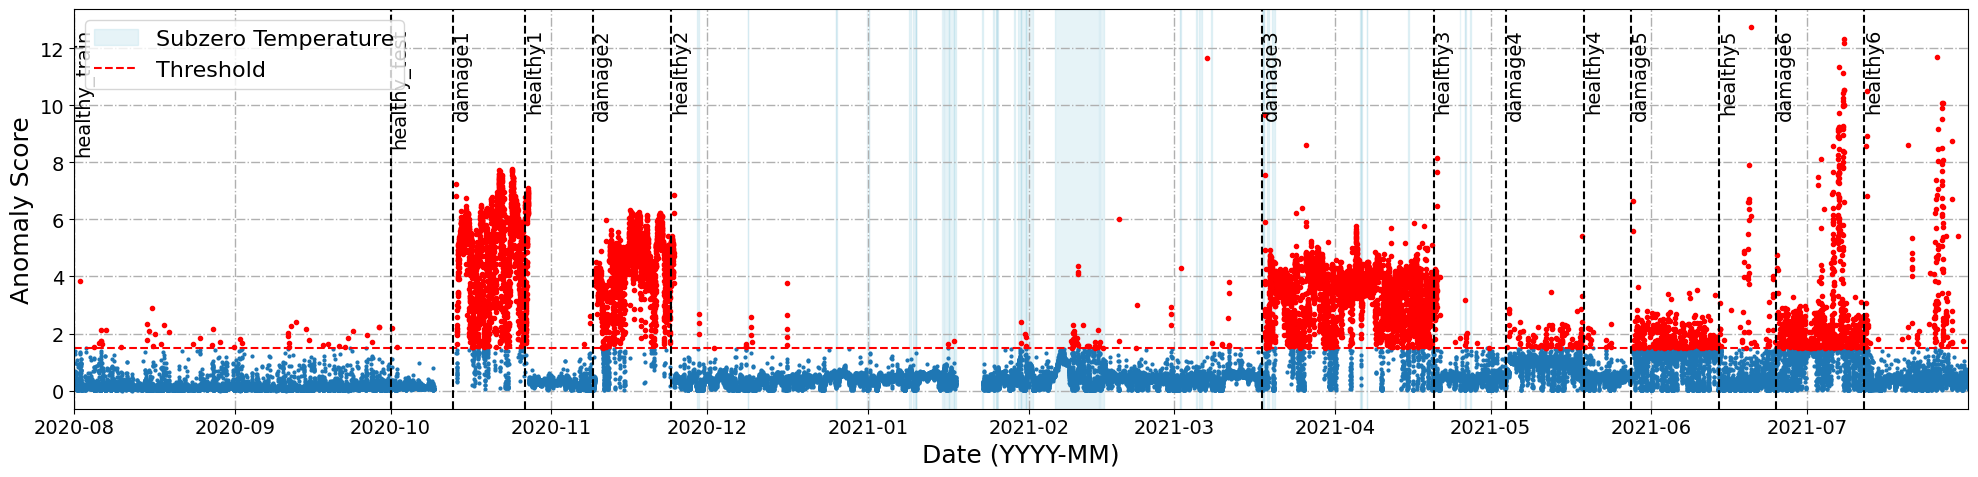

In [74]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ---------------------------
# Update Publication Quality Settings with Increased Fonts
# ---------------------------
plt.rcParams.update({
    'font.size': 14,         # Base font size
    'axes.labelsize': 18,    # X and Y label font size
    'axes.titlesize': 20,    # Axes title font size
    'legend.fontsize': 16,   # Legend font size
    'xtick.labelsize': 14,   # X-tick label size
    'ytick.labelsize': 14,   # Y-tick label size
    'lines.linewidth': 1.5,
    'grid.linestyle': '-.',
    'grid.linewidth': 1,
})

# Define the column of interest (e.g., mean_mse).
col_of_interest = 'mean_mse'

# ---------------------------
# 1. Create Figure and Plot Main Control Chart
# ---------------------------
fig, ax = plt.subplots(figsize=(20, 5))

# Plot anomaly scores as individual points.
ax.plot(
    df_agg.index, 
    df_agg[col_of_interest],
    'o', 
    markersize=2, 
    color='tab:blue', 
)

# Compute threshold (99.5th percentile over the training period).
train_start = pd.to_datetime(settings.state.healthy_train.start)
train_end = pd.to_datetime(settings.state.healthy_train.end)
df_train = df_agg.loc[train_start:train_end]
threshold = df_train[col_of_interest].quantile(0.995)

# Plot the threshold as a horizontal dashed red line.
ax.axhline(threshold, color='red', linestyle='--', label='Threshold')

# Highlight points exceeding the threshold.
exceed_mask = df_agg[col_of_interest] > threshold
ax.plot(
    df_agg.index[exceed_mask],
    df_agg.loc[exceed_mask, col_of_interest],
    'o', 
    markersize=3, 
    color='red',
)

# ---------------------------
# 2. Shade Subzero Temperature Regions
# ---------------------------
# Assume 'date_subzero_temperature' is a DataFrame with 'start_time' and 'end_time' columns.
for _, row in date_subzero_temperature.iterrows():
    ax.axvspan(
        row['start_time'], 
        row['end_time'], 
        color='lightblue', 
        alpha=0.3, 
        zorder=0
    )

# Create a patch for the legend.
subzero_patch = mpatches.Patch(color='lightblue', alpha=0.3, label='Subzero Temperature')

# ---------------------------
# 3. Add Legend and Annotate Events
# ---------------------------
# Combine existing legend handles with the subzero patch.
handles, labels = ax.get_legend_handles_labels()
handles.insert(0, subzero_patch)
labels.insert(0, 'Subzero Temperature')
ax.legend(handles, labels, loc='upper left', frameon=True)

# Annotate events from settings, if any.
for event_i, event_info in settings.state.to_dict().items():
    start = pd.to_datetime(event_info['start'])
    # Draw a vertical dashed line at the event start.
    ax.axvline(start, color='black', linestyle='--', label=f'{event_i} start')
    # Optionally, add text annotation near the top of the plot.
    ax.text(
        start, 
        ax.get_ylim()[1] * 0.95, 
        f'{event_i}', 
        rotation=90, 
        va='top', 
        ha='left'
    )

# ---------------------------
# 4. Final Touches
# ---------------------------
ax.set_xmargin(0)
ax.set_xlabel('Date (YYYY-MM)', fontsize=18)  # Increased label font size
ax.set_ylabel('Anomaly Score', fontsize=18)    # Increased label font size
ax.grid(True)

plt.tight_layout()

# Save the figure at high resolution (300 dpi) for journal publication.
plt.savefig("journal_plot.png", dpi=300)
plt.show()


In [80]:
df_plot_meteo.index = df_plot_meteo.index + pd.Timedelta(minutes=10)   
df_merge_temp = pd.merge_asof(df_agg,df_plot_meteo, 
                            left_index=True, right_index=True, direction='nearest')


In [81]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Example: Focus on level=1 data or a specific label. Adjust as needed.
# (If you already have df_res_level_meteo, skip re-assigning it.)
df_plot = df_merge_temp.copy()

# Drop rows missing MSE or Temperature.
df_plot = df_plot.dropna(subset=['mean_mse', 'airTemperatureAt2m'])


In [82]:
from hannover_pylon.utils.evaluation import label_dataframe_event 
df_plot['label']=label_dataframe_event(df_plot.index,events=settings.state.to_dict())
df_plot['label'].unique()

array(['healthy_train', 'healthy_test', 'damage1', 'healthy1', 'damage2',
       'healthy2', 'damage3', 'healthy3', 'damage4', 'healthy4',
       'damage5', 'healthy5', 'damage6', 'healthy6'], dtype=object)

/tmp/ipykernel_8112/1878487454.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_healthy_2.groupby('temp_bin')


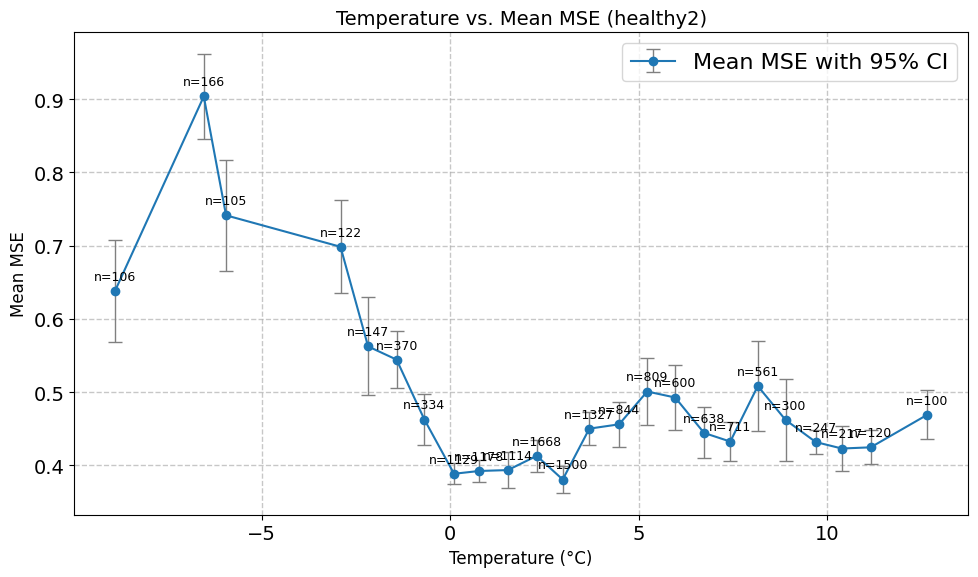

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import t, pearsonr

# Assume df_plot is your merged DataFrame that contains:
# - 'airTemperatureAt2m': temperature readings,
# - 'mean_mse': the 2-hour rolling median of MSE (or your chosen aggregated anomaly score),
# - 'label': event/health label.

# Filter to the desired label (for example, "healthy2")
df_healthy_2 = df_plot[df_plot['label'] == 'healthy2'].copy()

# Create bins for temperature.
# Here we use 50 bins; adjust this number as needed.
df_healthy_2['temp_bin'] = pd.cut(df_healthy_2['airTemperatureAt2m'], bins=50)

# Group by these temperature bins.
grouped = df_healthy_2.groupby('temp_bin')

# Compute aggregated statistics per bin.
mean_temp = grouped['airTemperatureAt2m'].mean()        # Mean temperature in each bin
mean_mse = grouped['mean_mse'].mean()                     # Mean MSE in each bin
std_mse = grouped['mean_mse'].std()                       # Standard deviation of MSE
count_mse = grouped['mean_mse'].count()                   # Number of observations per bin

# Compute the standard error of the mean.
sem_mse = std_mse / np.sqrt(count_mse)

# Compute the t-critical value for a 95% confidence interval for each bin.
confidence_level = 0.95
# Degrees of freedom per bin
dof = count_mse - 1
dof[dof < 1] = np.nan  # Avoid errors for bins with too few samples
t_crit = t.ppf((1 + confidence_level) / 2, dof)

# Compute the margin of error.
margin_of_error = t_crit * sem_mse

# Filter out bins with fewer than 100 samples.
valid_bins = count_mse >= 100
mean_temp_valid = mean_temp[valid_bins]
mean_mse_valid = mean_mse[valid_bins]
margin_error_valid = margin_of_error[valid_bins]
count_valid = count_mse[valid_bins]

# Plot the binned data with error bars.
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(
    mean_temp_valid, 
    mean_mse_valid, 
    yerr=margin_error_valid,
    fmt='o-', capsize=5, ecolor='gray', elinewidth=1, markeredgewidth=1,
    label='Mean MSE with 95% CI'
)

ax.set_xlabel('Temperature (°C)', fontsize=12)
ax.set_ylabel('Mean MSE', fontsize=12)
ax.set_title('Temperature vs. Mean MSE (healthy2)', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)

# Annotate each point with the sample size.
for x, y, n in zip(mean_temp_valid, mean_mse_valid, count_valid):
    ax.annotate(f'n={int(n)}', xy=(x, y), xytext=(0, 8),
                textcoords='offset points', ha='center', fontsize=9)



plt.legend()
plt.tight_layout()
plt.show()


In [84]:
from evaluation_lumo.evaluation import compute_tr_by_events, compute_median_variation, prepare_dataframe
from hannover_pylon.modelling.finalexp.plot import display_damage_vs_healthy_table 
scores = compute_tr_by_events(df_agg.index,df_agg['mean_mse'])[0]
display_damage_vs_healthy_table(scores)
scores = compute_median_variation(df_agg.index,df_agg['mean_mse'])  
display_damage_vs_healthy_table(scores)


                              Damage vs. Healthy                              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Damage Event         ┃ Damage Score ┃ Healthy Event        ┃ Healthy Score ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ damage1              │       0.9305 │ healthy1             │        0.0028 │
│ damage2              │       0.9235 │ healthy2             │        0.0166 │
│ damage3              │       0.8473 │ healthy3             │        0.0218 │
│ damage4              │       0.1080 │ healthy4             │        0.0161 │
│ damage5              │       0.5251 │ healthy5             │        0.0501 │
│ damage6              │       0.6128 │ healthy6             │        0.0539 │
│                      │              │ healthy_test         │        0.0017 │
│                      │              │ healthy_train        │        0.0100 │
└──────────────────────┴──────────────┴──────────────────────┴───────────────┘

             Others              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Event                ┃  Score ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ no_event             │ 0.4921 │
└──────────────────────┴────────┘

                              Damage vs. Healthy                              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Damage Event         ┃ Damage Score ┃ Healthy Event        ┃ Healthy Score ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ damage1              │      44.1155 │ healthy1             │        2.6231 │
│ damage2              │      40.3117 │ healthy2             │        3.8764 │
│ damage3              │      31.4633 │ healthy3             │        4.0575 │
│ damage4              │       8.9877 │ healthy4             │        4.1220 │
│ damage5              │      11.2849 │ healthy5             │        2.8445 │
│ damage6              │      12.7770 │ healthy6             │        3.2352 │
│                      │              │ healthy_test         │        1.2348 │
│                      │              │ healthy_train        │        0.8517 │
└──────────────────────┴──────────────┴──────────────────────┴───────────────┘

              Others              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Event                ┃   Score ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ no_event             │ 10.7044 │
└──────────────────────┴─────────┘